# Pattern Spectrum   
**Data**    
Drone imagery sourced from [OpenAerialMap(OAM)](https://map.openaerialmap.org/#/14.765625,46.56641407568593,6?_k=knjlmg). 

In [1]:
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt
import sap
from pathlib import Path
import matplotlib as mpl

Some preprocessing doen on the imagery, i.e. cropping to reduce teh size of the imagery for faster compuattion

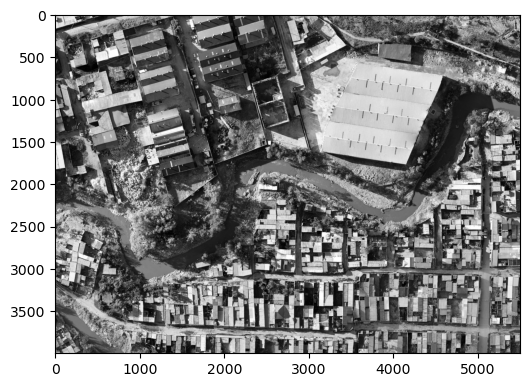

In [2]:
# load data
data_dir = Path("data")

input = rio.open(data_dir / "njiru_kenya.tif")
rgb = input.read(1)
img = rgb[1000:5000, 2500:8000] # crop for faster processing

# view
plt.figure(figsize=(6, 6))
plt.imshow(img, cmap='gray')

### Tree Construction  
The MaxTree is constructed to enable the easier identification of building structures. 


In [3]:
tree = sap.trees.MaxTree(img)
print(tree)

MaxTree{'adjacency': 4,
 'image.dtype': dtype('uint8'),
 'image.shape': (4000, 5500),
 'image_hash': '0aa6cd27',
 'image_name': None,
 'num_nodes': 26043347}


## Attributes  
To detect buildings, especially in very dense imagery, the following attributes were selected:  

- **Area** represents the spatial extent of connected components. Buildings, particularly larger ones, occupy a wider area (more pixels), while smaller objects have fewer pixels in their regions.  
- **Mean Vertex Weights** represents the average brightness of each component. Buildings typically have higher intensity compared to darker surfaces such as water or shadows.  
- **Area × Height**: Derived from the area and the height which measures the contrast of a component relative to its surroundings. It emphasizes large, bright objects, helping to differentiate buildings from smaller or less prominent bright features such as roads or vehicles.

These attributes were chosen to capture the shape and specral charactreistics of buildings.



In [21]:
# area 
area = tree.get_attribute('area')
print('area:', area, 'shape', area.shape)

# momnet of inertia
height = tree.get_attribute('moment_of_inertia')
area_height = area * height
print('area_height:', area_height, 'shape', area_height.shape)

# mean vertex weights
intensity = tree.get_attribute('mean_vertex_weights') 
print('intensity:', intensity, 'shape', intensity.shape)

area: [1.0e+00 1.0e+00 1.0e+00 ... 2.0e+00 1.0e+00 2.2e+07] shape (26043347,)
area_height: [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 2.5000000e-01 0.0000000e+00
 3.8541665e+06] shape (26043347,)
intensity: [ 25.          18.          18.         ...   1.           1.
 110.58918182] shape (26043347,)


## Pattern spectrum  
plot the distribution of the attributes specifically area vs intensity and area vs area*height

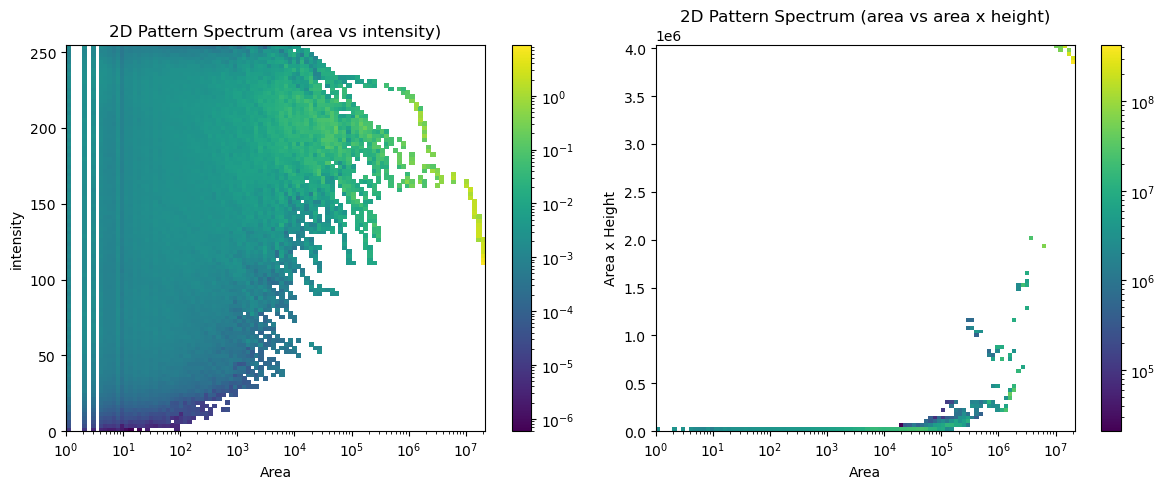

In [14]:
# Define bins (log-spaced for area)
bins_area =  np.geomspace(1, img.size, 100 + 1)
bins_height = np.linspace(area_height.min(), area_height.max(), 100)

# Compute weights for histogramming
altitudes = tree._alt
parent_altitudes = altitudes[tree._tree.parents()]
delta_altitudes = altitudes - parent_altitudes
weights = area * delta_altitudes

# Plot 2D pattern spectra 
ps = sap.spectrum2d(tree, 'area', 'mean_vertex_weights', x_log=True)
ps2 = sap.spectrum2d(tree, 'area', 'moment_of_inertia', x_log=True)

plt.figure(figsize=(12,5))

plt.subplot(1,2, 1) 
sap.show_spectrum(*ps)
plt.xlabel('Area')
plt.ylabel('intensity')
plt.colorbar()
plt.title('2D Pattern Spectrum (area vs intensity)')

plt.subplot(1, 2, 2)
plt.hist2d(area, area_height, bins=(bins_area, bins_height), norm=mpl.colors.LogNorm(), weights=weights)
plt.xlabel('Area')
plt.xscale('log')
plt.ylabel('Area x Height')
plt.colorbar()
plt.title('2D Pattern Spectrum (area vs area x height)')

plt.tight_layout()
plt.show()

## Attribute filtering
The thresholds were determined form the pattern spectrum.   
Buildings will tend to have higher area and thus we focus on the right side of both spectrums. The intensity of buildings will be moderate to high but not 255 whereas the combination of attribute and height for buildings will have a relatively moderate to high value.

Deleted nodes: 26043264 Kept nodes: 83


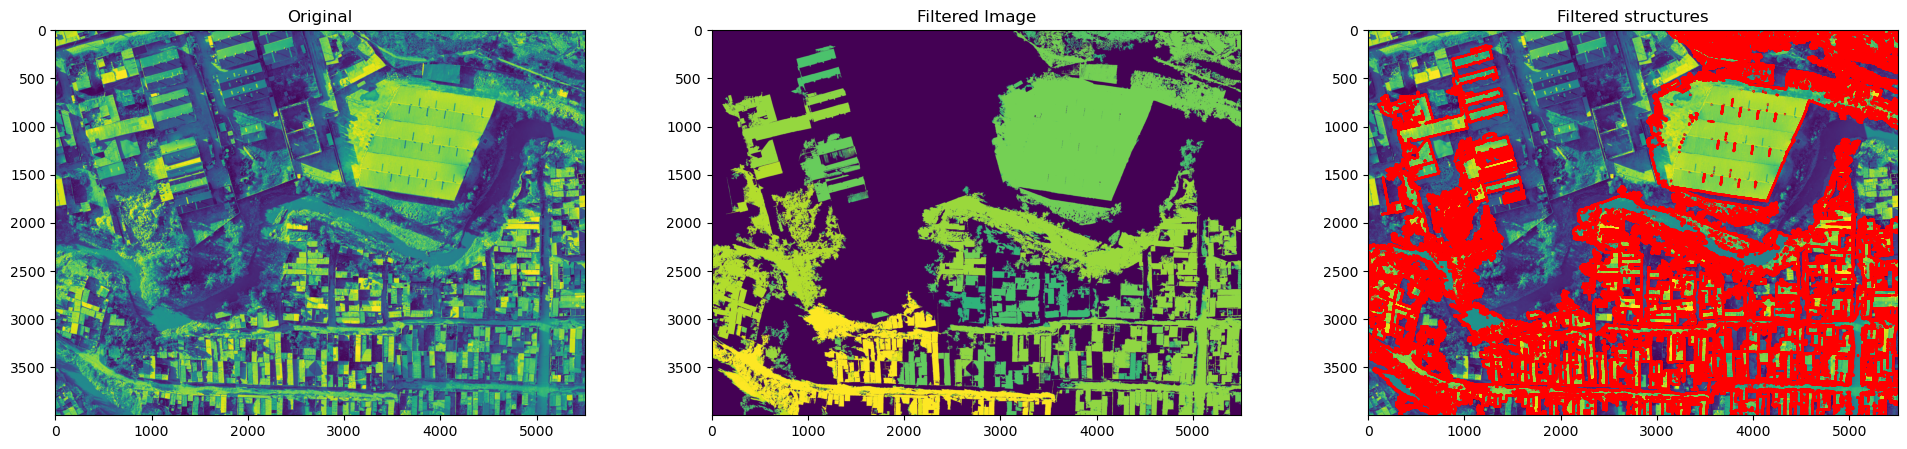

In [22]:
# threshold
area_min, area_max = 10**6 ,10**8              
area_height_min, area_height_max = 0.5e6 , 2.0e6  
intensity_min = 150 

# delete nodes vectors
keep_nodes_area  = (area > area_min) 
keep_nodes_intensity   = (intensity > intensity_min) 
keep_nodes_height = (area_height > area_height_min) & (area_height < area_height_max)

keep_nodes = keep_nodes_area & keep_nodes_height & keep_nodes_intensity 

#deleted nodes
deleted_nodes = ~keep_nodes

print("Deleted nodes:", deleted_nodes.sum(), "Kept nodes:", deleted_nodes.size - deleted_nodes.sum())

img_filtered = tree.reconstruct(deleted_nodes)

plt.figure(figsize=(24, 5))

plt.subplot(1,3,1)
plt.imshow(img)
plt.title('Original')

plt.subplot(1,3,2)
plt.imshow(img_filtered)
plt.title('Filtered Image')

plt.subplot(1,3,3)
plt.imshow(img)
plt.contour(img_filtered, colors='red')
plt.title('Filtered structures')

plt.show()

## Evaluation on different images
Images from the same source as the initial image are evaluated against the defined attributes and threshold. The images have different landscape than the initial image.

(np.float64(-0.5), np.float64(3499.5), np.float64(3999.5), np.float64(-0.5))

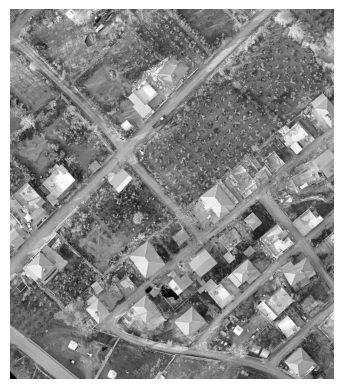

In [9]:
src = rio.open(data_dir / "img1.tif")
rgb = src.read(1)
img2 = rgb[3000:7000, 2000:5500] # crop for faster processing

plt.imshow(img2, cmap='gray')
plt.axis('off')

In [10]:
# construct max-tree
tree_ts1 = sap.trees.MaxTree(img2)
print(tree_ts1)

MaxTree{'adjacency': 4,
 'image.dtype': dtype('uint8'),
 'image.shape': (4000, 3500),
 'image_hash': 'd3eaf1ec',
 'image_name': None,
 'num_nodes': 17198506}


area: [1.0e+00 1.0e+00 1.0e+00 ... 1.0e+00 1.0e+00 1.4e+07] shape (17198506,)
area_height: [      0.        0.        0.  ...       0.        0.  2354166.5] shape (17198506,)
intensity: [ 53.        45.        49.       ...   1.         1.       129.276844] shape (17198506,)
Deleted nodes: 17198488 Kept nodes: 18


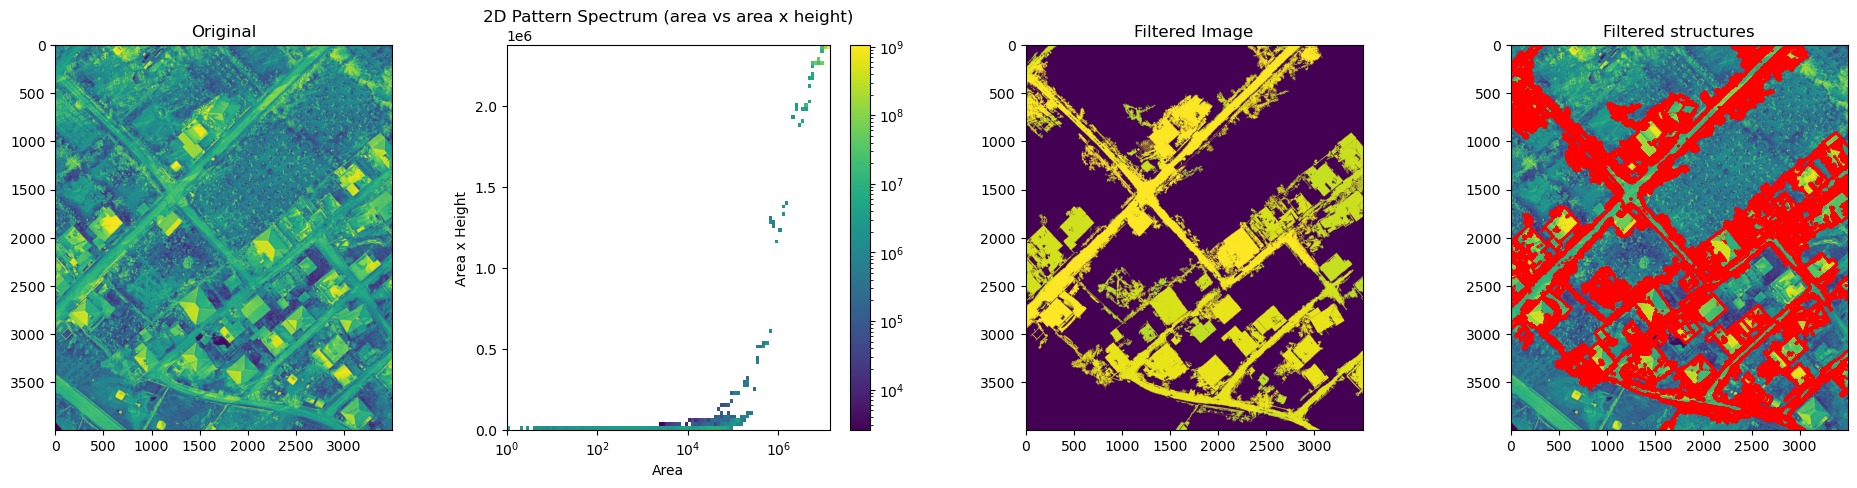

In [25]:
# ---------------Inintial attributes for this tree-----------
# area 
area = tree_ts1.get_attribute('area')
print('area:', area, 'shape', area.shape)

# moment of inertia
height = tree_ts1.get_attribute('moment_of_inertia')
area_height = area * height
print('area_height:', area_height, 'shape', area_height.shape)

# mean vertex weights
intensity = tree_ts1.get_attribute('mean_vertex_weights') 
print('intensity:', intensity, 'shape', intensity.shape)

##------------- rerun delete nodes vectors--------------
# delete nodes vectors
keep_nodes_area  = (area > area_min) 
keep_nodes_intensity   = (intensity > intensity_min) 
keep_nodes_height = (area_height > area_height_min) & (area_height < area_height_max)

keep_nodes = keep_nodes_area & keep_nodes_height & keep_nodes_intensity

# deleted nodes
deleted_nodes = ~keep_nodes
print("Deleted nodes:", deleted_nodes.sum(), "Kept nodes:", deleted_nodes.size - deleted_nodes.sum())

# filter the tree and reconstruct image
img_filtered = tree_ts1.reconstruct(deleted_nodes)

# Define bins (log-spaced for area)
bins_area =  np.geomspace(1, img2.size, 100 + 1)
bins_height = np.linspace(area_height.min(), area_height.max(), 100)

# Compute weights for histogram
altitudes = tree_ts1._alt
parent_altitudes = altitudes[tree_ts1._tree.parents()]
delta_altitudes = altitudes - parent_altitudes
weights = area * delta_altitudes

##-------------- Plot 2D pattern spectra and filtered image---------------------- 
ps = sap.spectrum2d(tree_ts1, 'area', 'mean_vertex_weights', x_log=True)

plt.figure(figsize=(24, 5))
plt.subplot(1,4,1)
plt.imshow(img2)
plt.title('Original')

plt.subplot(1,4,2)
plt.hist2d(area, area_height, bins=(bins_area, bins_height), norm=mpl.colors.LogNorm(), weights=weights)
plt.xlabel('Area')
plt.xscale('log')
plt.ylabel('Area x Height')
plt.colorbar()
plt.title('2D Pattern Spectrum (area vs area x height)')

plt.subplot(1,4,3)
plt.imshow(img_filtered)
plt.title('Filtered Image')

plt.subplot(1,4,4)
plt.imshow(img2)
plt.contour(img_filtered, colors='red')
plt.title('Filtered structures')

plt.show()

(np.float64(-0.5), np.float64(3999.5), np.float64(3999.5), np.float64(-0.5))

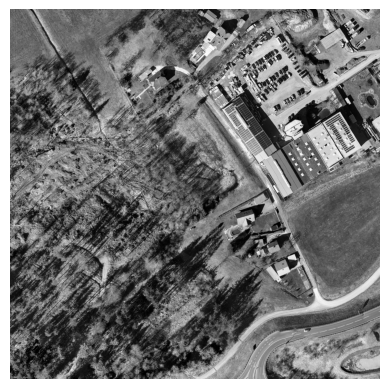

In [26]:
src = rio.open(data_dir / "img2.tif")
rgb = src.read(1)
img3 = rgb[ 2000:6000, 6500:10500] # crop for faster processing

plt.imshow(img3, cmap='gray')
plt.axis('off')

In [27]:
tree_ts2 = sap.trees.MaxTree(img3)
print(tree_ts2)

MaxTree{'adjacency': 4,
 'image.dtype': dtype('uint8'),
 'image.shape': (4000, 4000),
 'image_hash': 'b9065230',
 'image_name': None,
 'num_nodes': 19394602}


area: [1.0e+00 1.0e+00 1.0e+00 ... 2.0e+01 1.0e+00 1.6e+07] shape (19394602,)
area_height: [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 4.6275000e+00 0.0000000e+00
 2.6666665e+06] shape (19394602,)
intensity: [111.         112.         117.         ...   1.25         1.
 104.48894513] shape (19394602,)
Deleted nodes: 19394573 Kept nodes: 29


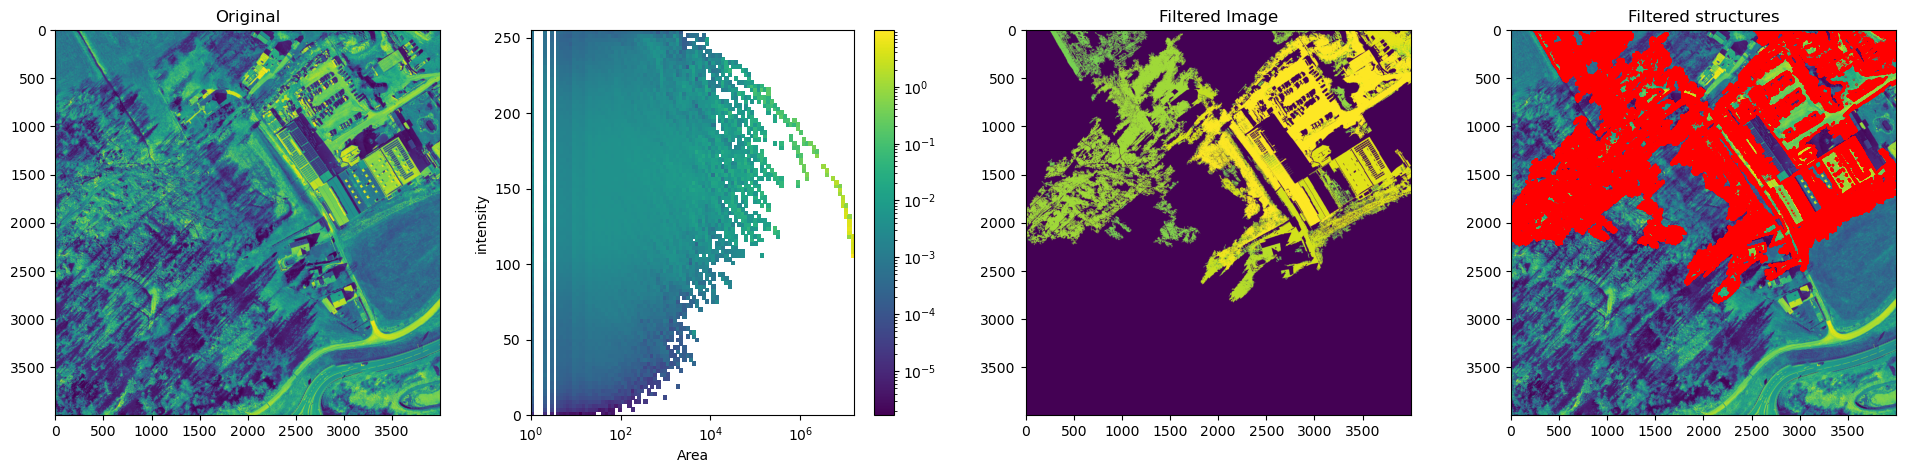

In [28]:
## ---------------Inintial attributes for this tree----------------
# area 
area = tree_ts2.get_attribute('area')
print('area:', area, 'shape', area.shape)

# moment of inertia
height = tree_ts2.get_attribute('moment_of_inertia')
area_height = area * height
print('area_height:', area_height, 'shape', area_height.shape)

# mean vertex weights
intensity = tree_ts2.get_attribute('mean_vertex_weights') 
print('intensity:', intensity, 'shape', intensity.shape)

## -------------rerun nodes to delete--------
# delete nodes vectors
keep_nodes_area  = (area > area_min) 
keep_nodes_intensity   = (intensity > intensity_min) 
keep_nodes_height = (area_height > area_height_min) & (area_height < area_height_max)

keep_nodes = keep_nodes_area & keep_nodes_height & keep_nodes_intensity

# deleted nodes
deleted_nodes = ~keep_nodes
print("Deleted nodes:", deleted_nodes.sum(), "Kept nodes:", deleted_nodes.size - deleted_nodes.sum())

# filter the tree and reconstruct image
img_filtered = tree_ts2.reconstruct(deleted_nodes)

# Define bins (log-spaced for area)
bins_area =  np.geomspace(1, img3.size, 100 + 1)
bins_height = np.linspace(area_height.min(), area_height.max(), 100)

# Compute weights for histogram
altitudes = tree_ts2._alt
parent_altitudes = altitudes[tree_ts2._tree.parents()]
delta_altitudes = altitudes - parent_altitudes
weights = area * delta_altitudes

##---------- Plot 2D pattern spectra and filtered image ------------
ps = sap.spectrum2d(tree_ts2, 'area', 'mean_vertex_weights', x_log=True)

plt.figure(figsize=(24, 5))
plt.subplot(1,4,1)
plt.imshow(img3)
plt.title('Original')

plt.subplot(1,4,2)
sap.show_spectrum(*ps)
plt.xlabel('Area')
plt.ylabel('intensity')
plt.colorbar()

plt.subplot(1,4,3)
plt.imshow(img_filtered)
plt.title('Filtered Image')

plt.subplot(1,4,4)
plt.imshow(img3)
plt.contour(img_filtered, colors='red')
plt.title('Filtered structures')

plt.show()